In [1]:
import random
import copy
import time
import pandas as pd
import numpy as np
import gc
import re
import torch

#import spacy
from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm

tqdm.pandas(desc='Progress')
from collections import Counter

from nltk import word_tokenize

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from sklearn.metrics import f1_score
import os 

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences # There's a PyTorch implementation but for Tensors.

# cross validation and metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from torch.optim.optimizer import Optimizer

from sklearn.preprocessing import StandardScaler
from multiprocessing import  Pool
from functools import partial
import numpy as np
from sklearn.decomposition import PCA
import torch as t
import torch.nn as nn
import torch.nn.functional as F

from dataclasses import dataclass

import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

Using TensorFlow backend.
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: GRID V100DX-8Q


In [3]:
embed_size = 300 # how big is each word vector
max_features = 40000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 750 # max number of words in a question to use
batch_size = 256 # how many samples to process at once
n_epochs = 5 # how many times to iterate over all samples
n_splits = 5 # Number of K-fold Splits
SEED = 10
debug = 0

In [4]:
mbti = pd.read_csv("../datasets/mbti_1.csv")

In [5]:
mbti.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [6]:
mbti = mbti[pd.notnull(mbti['posts'])]
mbti.posts = mbti.posts.str.replace('\|\|\|', ' ')

In [7]:
mbti['len'] = mbti['posts'].apply(lambda s : len(s))

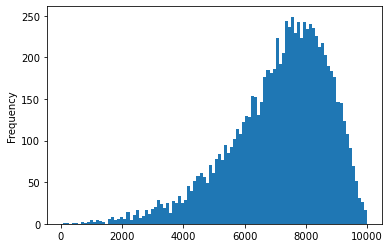

In [8]:
mbti['len'].plot.hist(bins=100)

In [9]:
count_df = mbti[['type','posts']].groupby('type').aggregate({'posts':'count'}).reset_index().sort_values('posts',ascending=False)
count_df

,type,posts
9,INFP,1832
8,INFJ,1470
11,INTP,1304
10,INTJ,1091
3,ENTP,685
1,ENFP,675
15,ISTP,337
13,ISFP,271
2,ENTJ,231
14,ISTJ,205


Targetting those above 600. The rest can be in others.

In [10]:
target_types = count_df[count_df['posts'] > 600]['type'].values

In [11]:
def types_parser(x):
    if x in target_types:
        return x
    else:
        return "OTHER"
    
mbti['type1'] = mbti['type'].apply(lambda x: types_parser(x))  

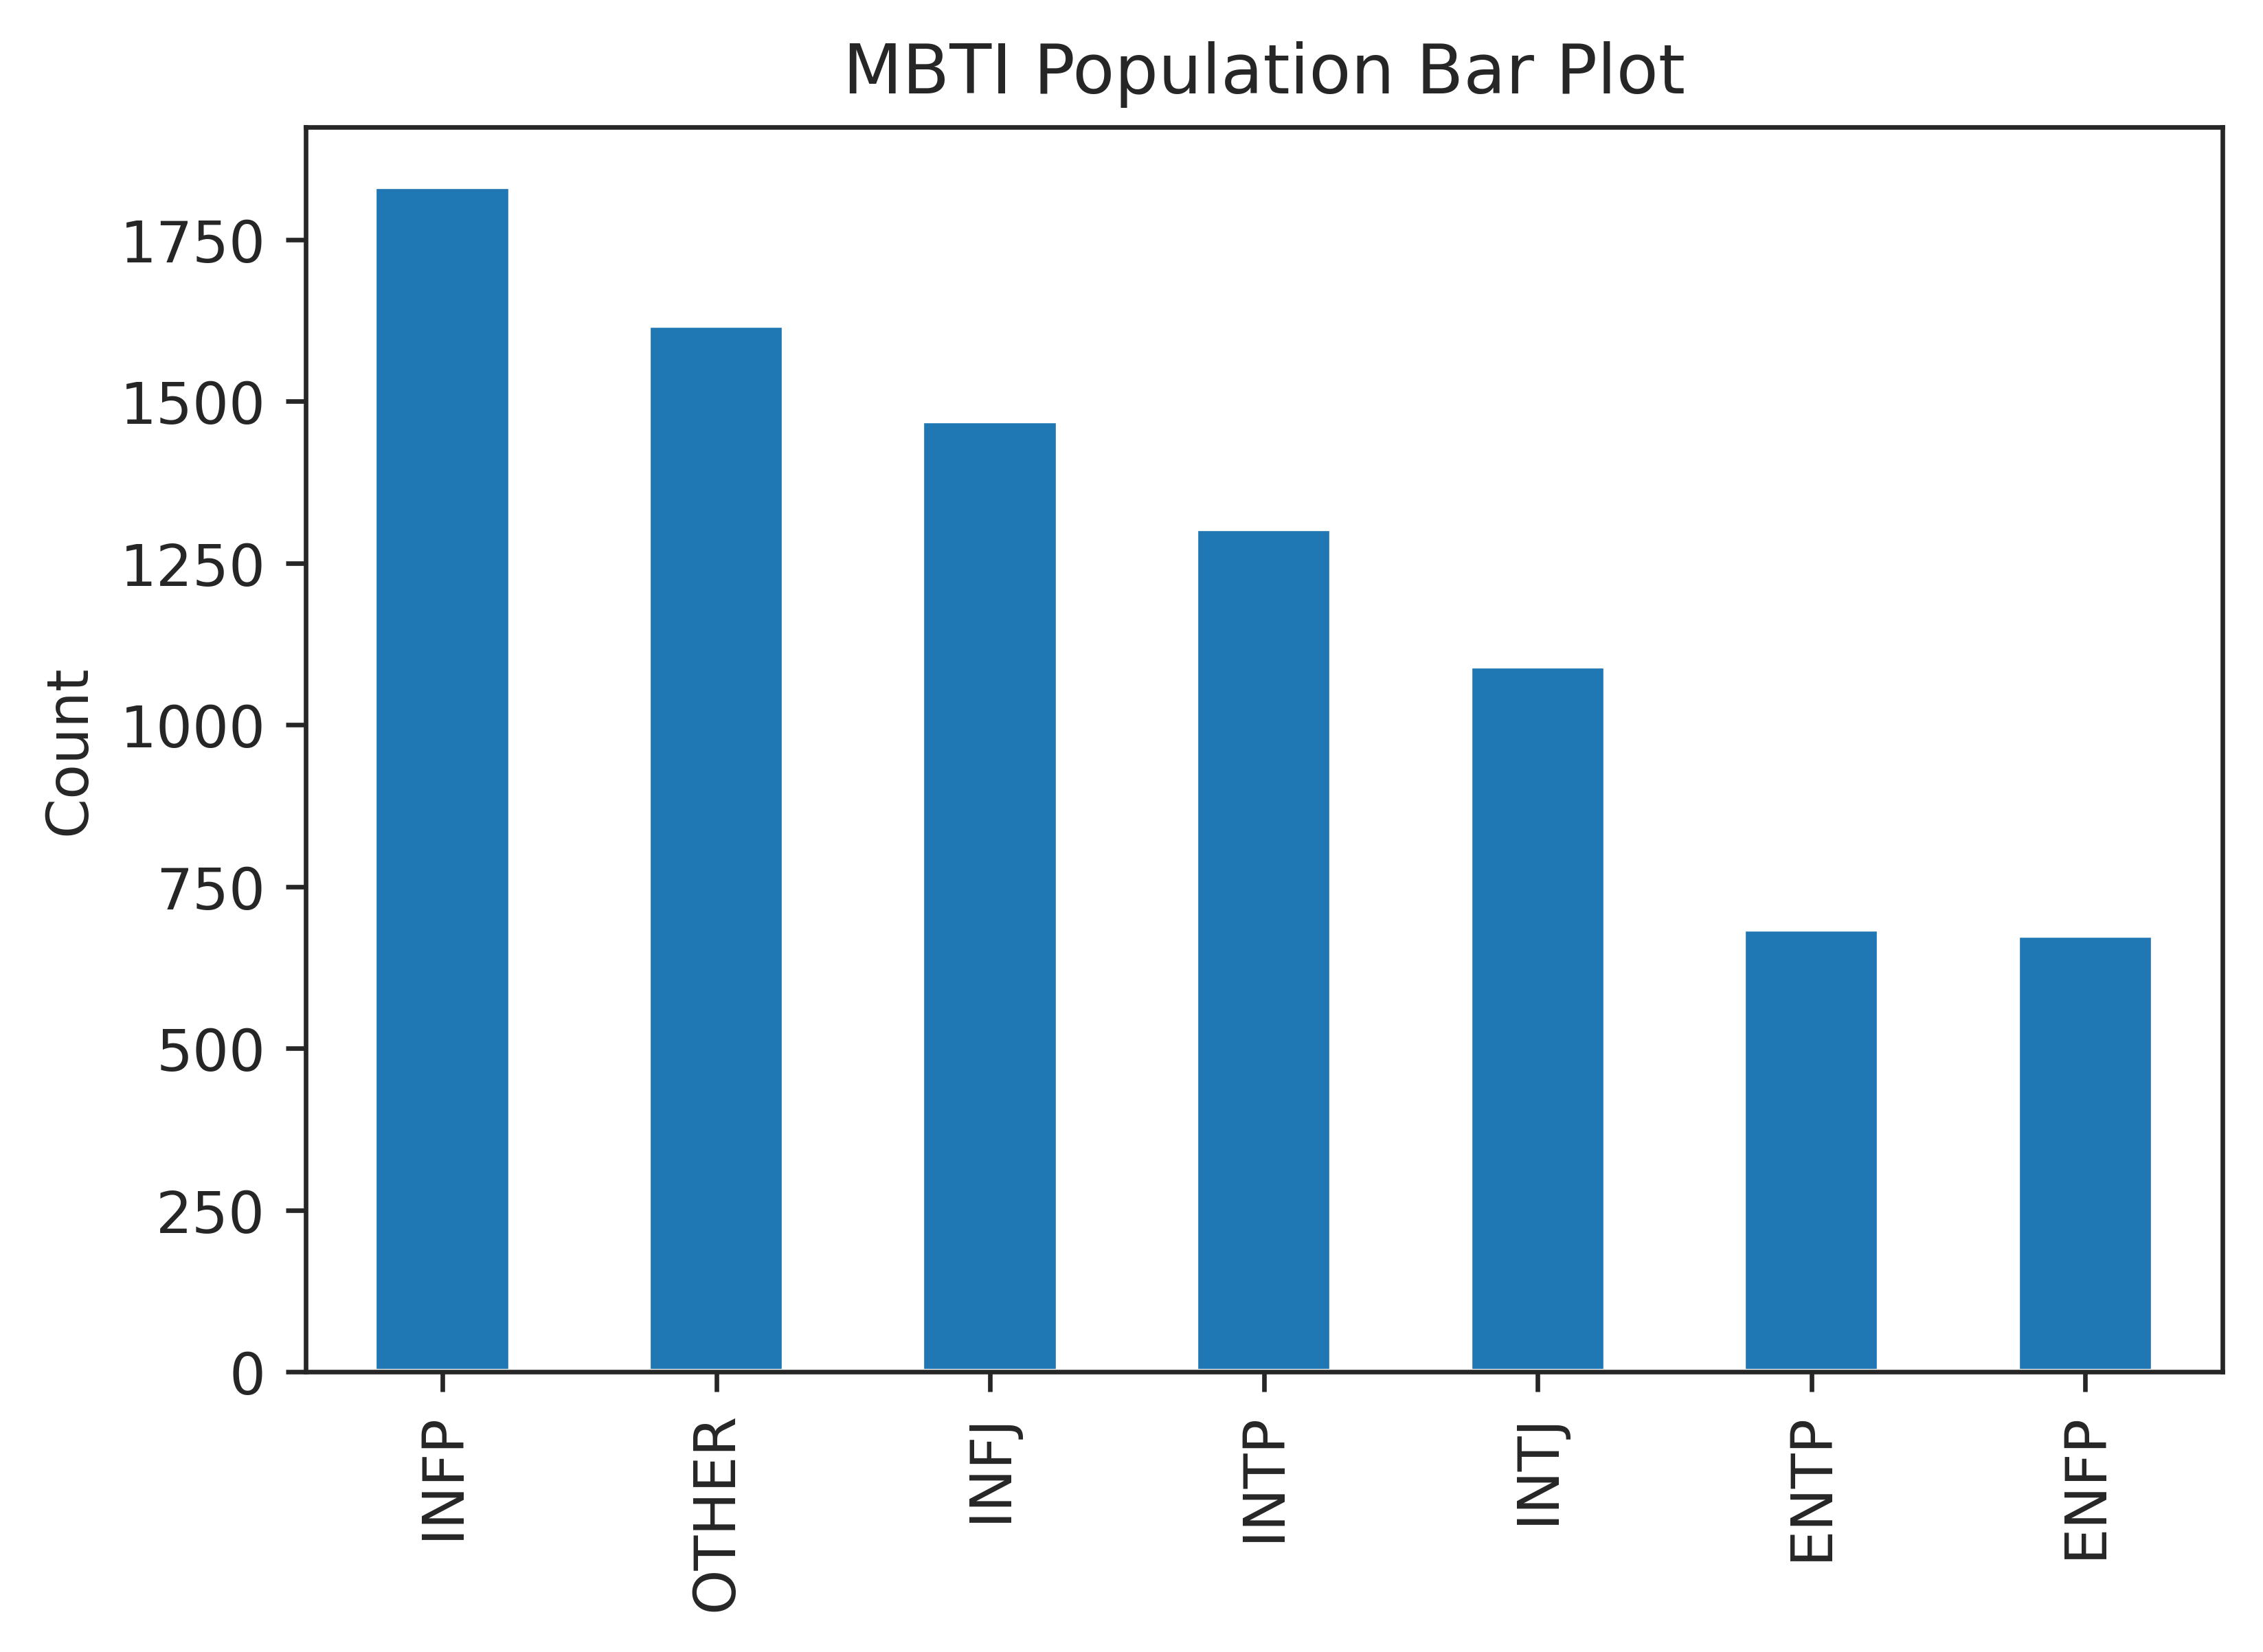

In [12]:
import seaborn as sns
sns.set_style("ticks")
plt.style.library['seaborn-colorblind'] # Care for the color-blind :")
plt.figure(dpi=600)
plt.title("MBTI Population Bar Plot")
plt.ylabel("Count")
mbti.type.value_counts().plot.bar()

mbti.type1.value_counts().plot.bar()

We use `type` for the actual types and `type1` for the filtered types.

In [13]:
!pip install contractions

In [14]:
# Prerequisites for this function
import re
import unicodedata
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import contractions

def preprocessing(text):
    """Preprocessing each row of text
    
    List of things done:
    - Lower casing
    - Remove URL links
    - Remove mention/hashtags (@anonymous, #anonymous)
    - Remove accented characters (changing to ASCII from UTF-8)
    - Remove punctuations, numbers, and irrelevant characters
    - Remove excess whitespace
    - Remove stop words in English
    - Normalise and lemmatise
    - Remove single characters
    
    Possible improvements:
    - Separating words from numbers (if it exists)
    - Convert emoji and chat lingo with proper form
    

    Args:
        text (str): String of text that needs to be preprocessed
    """
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub("@\S+", " ", text)
    text = re.sub("#\S+", " ", text)
    # text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    text = [contractions.fix(word) for word in text.split()]
    text = ' '.join([word for word in text])
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text) # re.sub(r'[^a-zA-Z0-9]', ' ', text) if we want numeric characters
    text = re.sub(r'^\s*|\s\s*', ' ', text).strip()
#     text = word_tokenize(text)
#     text = [token for token in text if token not in stopwords.words('english')]
#     text = [WordNetLemmatizer().lemmatize(word, pos='v') for word in text]
#     text = [WordNetLemmatizer().lemmatize(word, pos='a') for word in text]
#     text = [word for word in text if len(word) > 1]
#     text = ' '.join([word for word in text])
    return text

In [15]:
mbti.posts = mbti.posts.apply(preprocessing)

In [16]:
# mbti.to_pickle(path='../datasets/mbti.pkl')

In [17]:
# mbti.posts.tolist()

In [18]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(mbti['posts'],
                                                    mbti['type'],
                                                    stratify=mbti['type'], 
                                                    test_size=0.25)

In [19]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X)
test_X = pad_sequences(test_X)

In [20]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(train_y.values)
test_y = le.transform(test_y.values)

In [21]:
def load_glove(word_index):    
    EMBEDDING_FILE = '../input/embeddings/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if len(o)>100 and o.split(" ")[0] in word_index )

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    embedding_matrix = np.random.normal(emb_mean, emb_std, (max_features, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [22]:
embedding_matrix = load_glove(tokenizer.word_index)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3331: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [23]:
class CNN_Text(nn.Module):
    
    def __init__(self):
        super(CNN_Text, self).__init__()
        filter_sizes = [1,2,3,4,5]
        num_filters = 100
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(len(filter_sizes)*num_filters, n_classes)


    def forward(self, x):
        x = self.embedding(x)  
        x = x.unsqueeze(1)  
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = self.dropout(x)  
        logit = self.fc1(x) 
        return logit
    
class BiLSTM(nn.Module):
    
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.hidden_size = 64
        drp = 0.1
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)


    def forward(self, x):
        #rint(x.size())
        h_embedding = self.embedding(x)
        #_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [24]:
n_epochs = 30
model = CNN_Text()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
# optimizer = optim.Adadelta(filter(lambda p: p.requires_grad, model.parameters()),
#                                lr=0.01,
#                                rho=0.95)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1/30 	 loss=535.1912 	 val_loss=428.8837  	 val_acc=0.5118  	 time=8.45s
Epoch 2/30 	 loss=377.4580 	 val_loss=340.0184  	 val_acc=0.5869  	 time=8.71s
Epoch 3/30 	 loss=300.7667 	 val_loss=303.9181  	 val_acc=0.6233  	 time=9.13s
Epoch 4/30 	 loss=260.9327 	 val_loss=284.0868  	 val_acc=0.6482  	 time=8.56s
Epoch 5/30 	 loss=229.1243 	 val_loss=275.0513  	 val_acc=0.6496  	 time=8.02s
Epoch 6/30 	 loss=201.7479 	 val_loss=269.0661  	 val_acc=0.6713  	 time=8.71s
Epoch 7/30 	 loss=181.7031 	 val_loss=258.7089  	 val_acc=0.6828  	 time=9.13s
Epoch 8/30 	 loss=159.6248 	 val_loss=262.4257  	 val_acc=0.6722  	 time=8.57s
Epoch 9/30 	 loss=140.7349 	 val_loss=258.4279  	 val_acc=0.6856  	 time=8.01s
Epoch 10/30 	 loss=121.5289 	 val_loss=255.2741  	 val_acc=0.6911  	 time=8.69s
Epoch 11/30 	 loss=104.6759 	 val_loss=254.7509  	 val_acc=0.6943  	 time=9.11s
Epoch 12/30 	 loss=89.1128 	 val_loss=252.1770  	 val_acc=0.6962  	 time=8.56s
Epoch 13/30 	 loss=75.9075 	 val_loss=254.8801  	 

In [25]:
def predict_single(x):    
#     # lower the text
#     x = x.lower()
#     # Clean the text
#     x =  clean_text(x)
#     # Clean numbers
#     x =  clean_numbers(x)
#     # Clean Contractions
#     x = replace_contractions(x)
    # tokenize
    x = tokenizer.texts_to_sequences([x])
    # pad
    x = pad_sequences(x, maxlen=maxlen)
    # create dataset
    x = torch.tensor(x, dtype=torch.long).cuda()

    pred = model(x).detach()
    pred = F.softmax(pred).cpu().numpy()

    pred = pred.argmax(axis=1)

    pred = le.classes_[pred]
    return pred[0]

In [26]:
!pip install scikit-plot

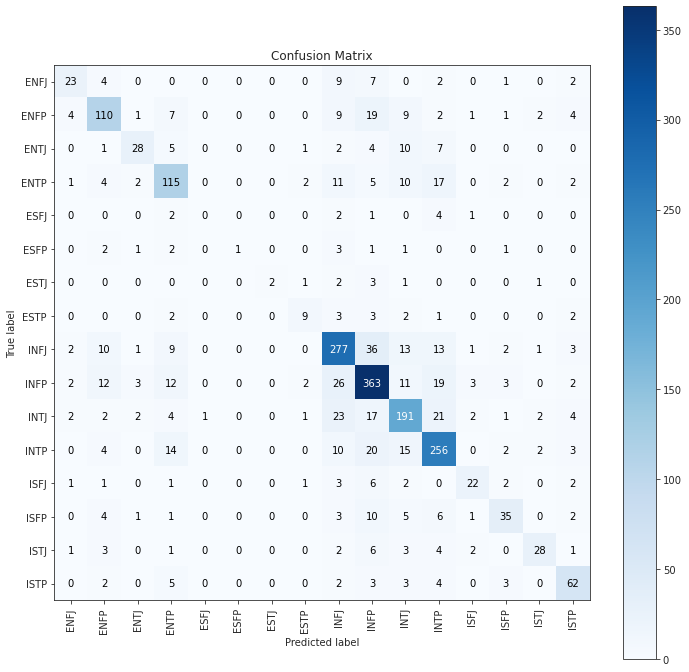

In [27]:
import scikitplot as skplt
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)

In [28]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        ENFJ       0.64      0.48      0.55        48
        ENFP       0.69      0.65      0.67       169
        ENTJ       0.72      0.48      0.58        58
        ENTP       0.64      0.67      0.66       171
        ESFJ       0.00      0.00      0.00        10
        ESFP       1.00      0.08      0.15        12
        ESTJ       1.00      0.20      0.33        10
        ESTP       0.53      0.41      0.46        22
        INFJ       0.72      0.75      0.73       368
        INFP       0.72      0.79      0.75       458
        INTJ       0.69      0.70      0.70       273
        INTP       0.72      0.79      0.75       326
        ISFJ       0.67      0.54      0.59        41
        ISFP       0.66      0.51      0.58        68
        ISTJ       0.78      0.55      0.64        51
        ISTP       0.70      0.74      0.72        84

    accuracy                           0.70      2169
   macro avg       0.68   

# Filtered Data

In [29]:
mbti_filtered = mbti.copy()

In [30]:
mbti_filtered = mbti_filtered[mbti_filtered.type1 != 'OTHER']

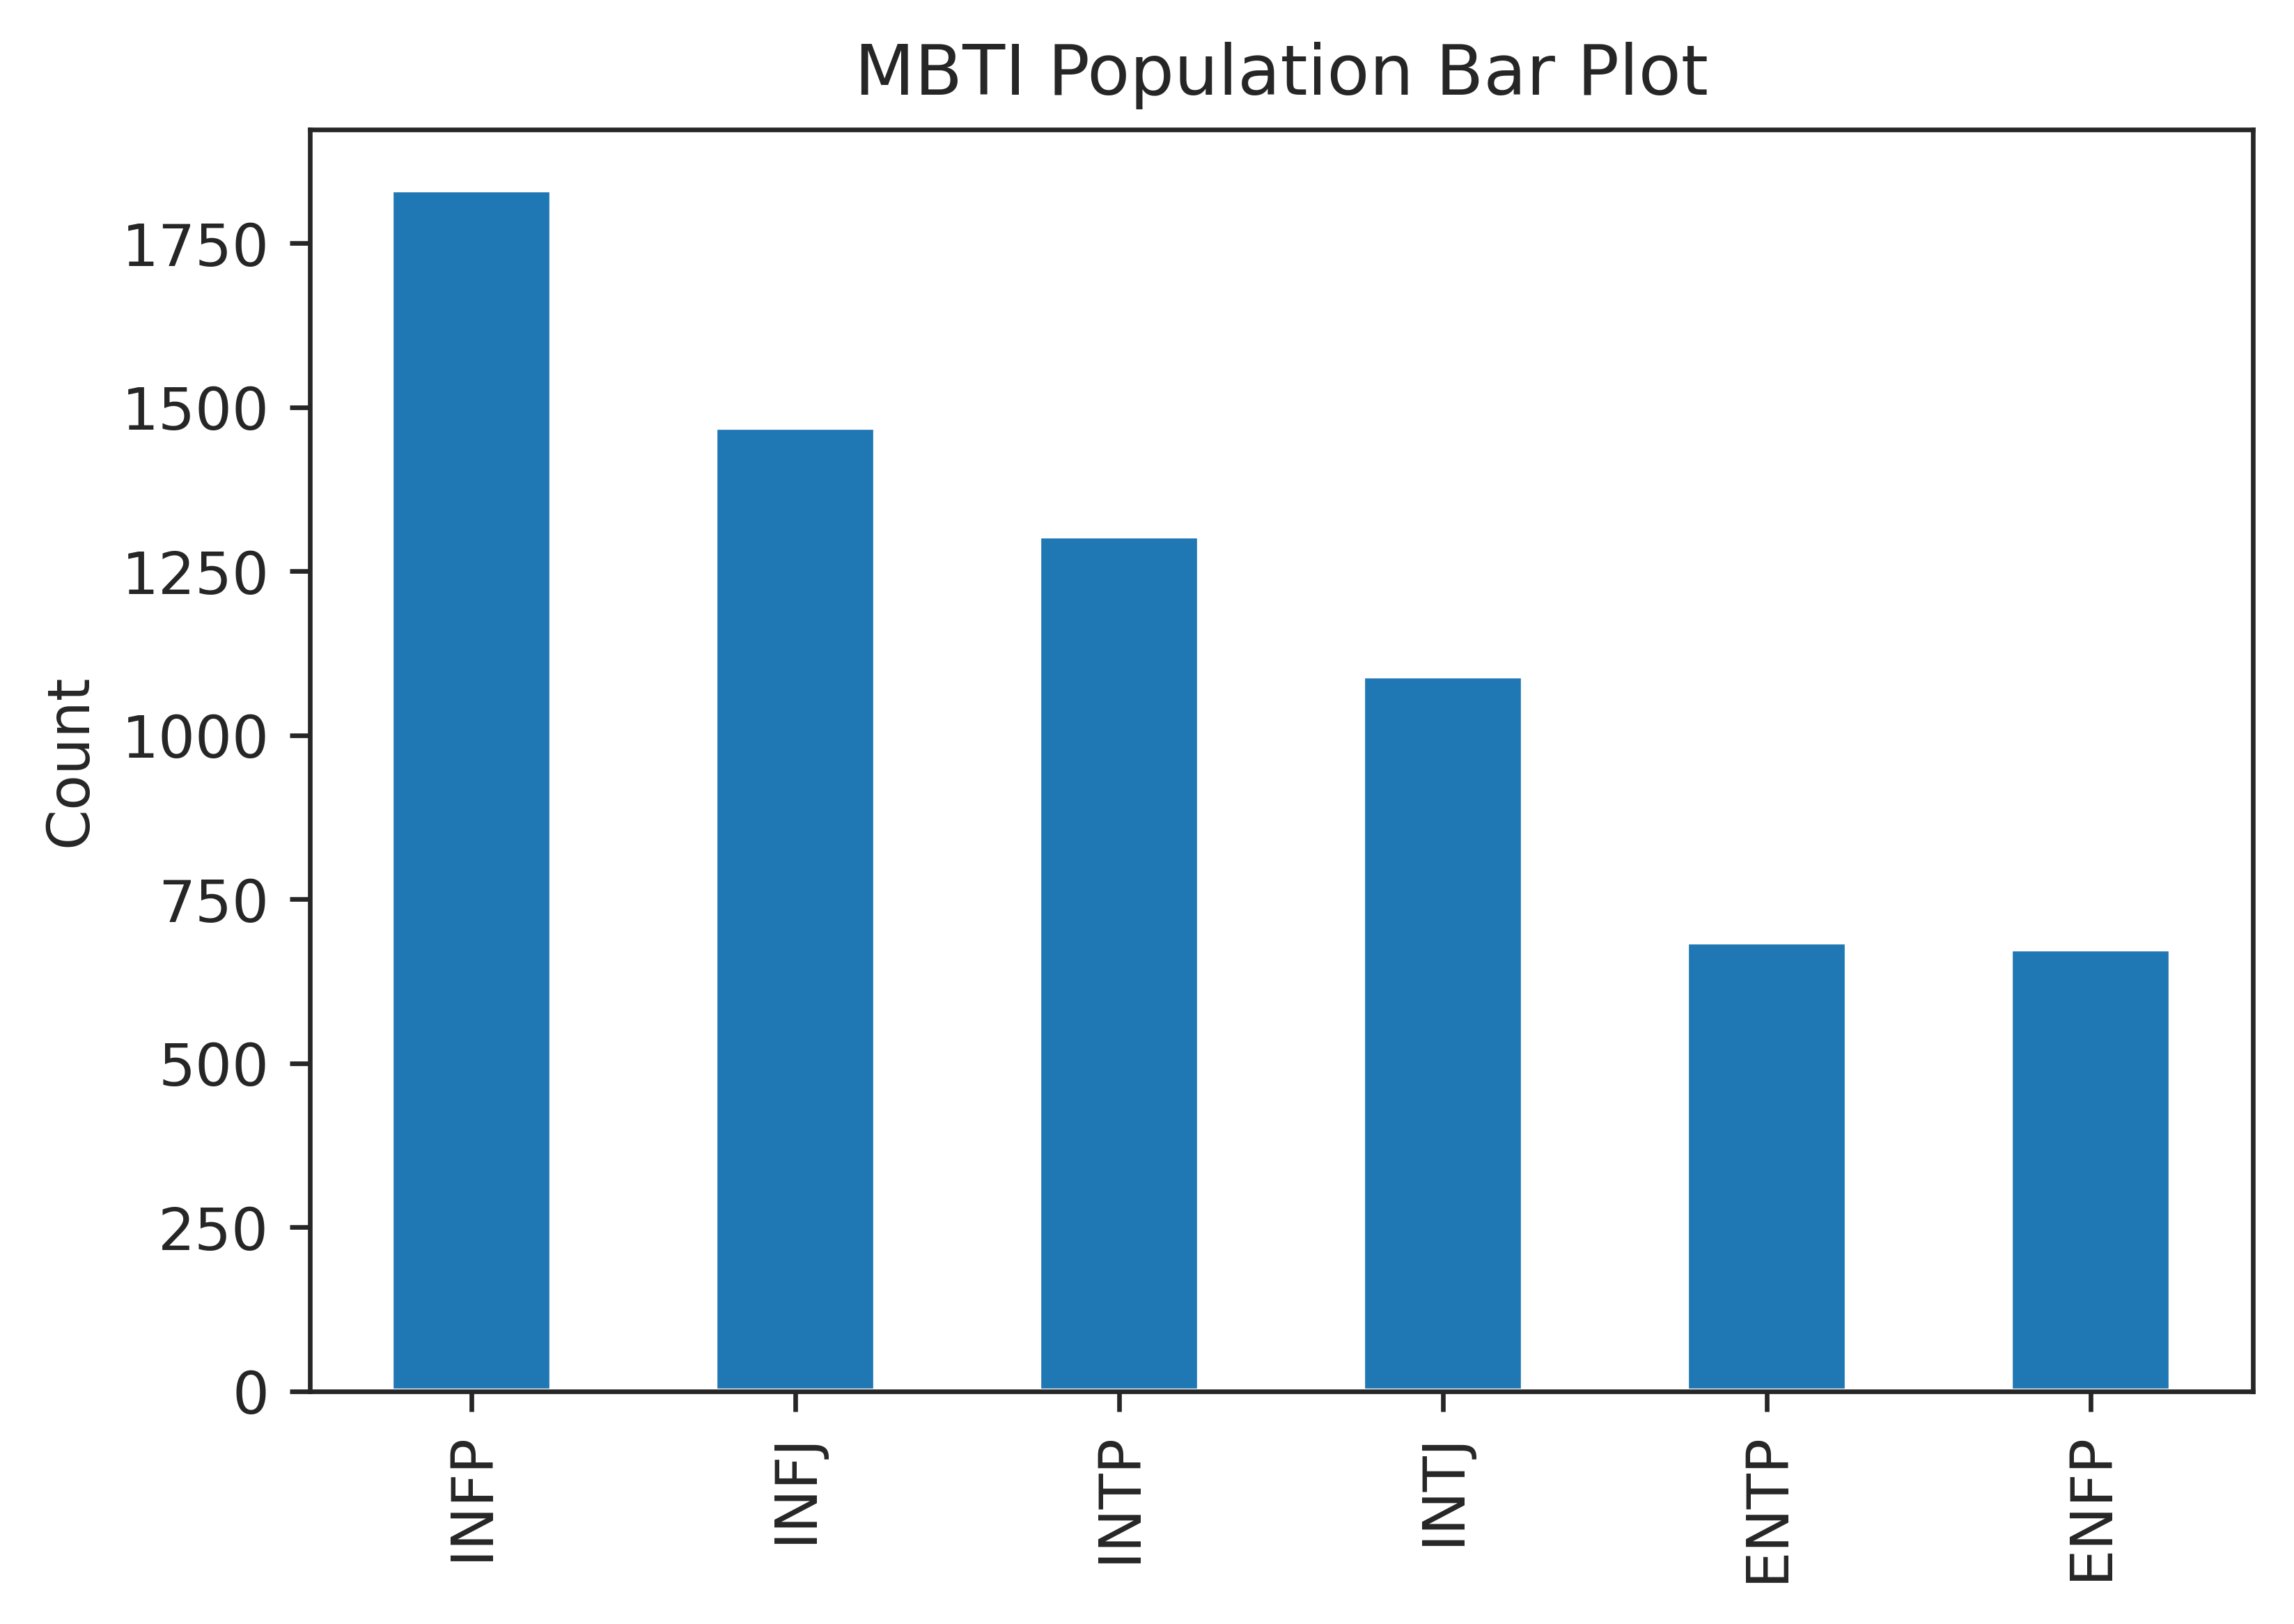

In [31]:
import seaborn as sns
sns.set_style("ticks")
plt.style.library['seaborn-colorblind'] # Care for the color-blind :")
plt.figure(dpi=600)
plt.title("MBTI Population Bar Plot")
plt.ylabel("Count")
mbti_filtered.type.value_counts().plot.bar()

## Preprocessing

In [32]:
mbti_filtered.posts = mbti_filtered.posts.apply(preprocessing)

In [33]:
mbti_filtered.to_pickle(path='../datasets/mbti_filtered.pkl')

# mbti_filtered = pd.read_pickle('../datasets/mbti_filtered.pkl')

## Test-train split

In [34]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(mbti_filtered['posts'],
                                                    mbti_filtered['type'],
                                                    stratify=mbti_filtered['type'], 
                                                    test_size=0.25)

## Tokenise and label

In [35]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X)
test_X = pad_sequences(test_X)

In [36]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(train_y.values)
test_y = le.transform(test_y.values)

# Word embedding

From [this notebook](https://www.kaggle.com/gmhost/gru-capsule/notebook).

In [37]:
def load_glove(word_index):    
    EMBEDDING_FILE = '../input/embeddings/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if len(o)>100 and o.split(" ")[0] in word_index )

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    embedding_matrix = np.random.normal(emb_mean, emb_std, (max_features, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [38]:
embedding_matrix = load_glove(tokenizer.word_index)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3331: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [39]:
len(embedding_matrix[0])

300

In [40]:
train_X.shape

(5292, 2006)

In [41]:
class CNN_Text(nn.Module):
    
    def __init__(self):
        super(CNN_Text, self).__init__()
        filter_sizes = [1,2,3,4,5]
        num_filters = 100
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(len(filter_sizes)*num_filters, n_classes)


    def forward(self, x):
        x = self.embedding(x)  
        x = x.unsqueeze(1)  
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = self.dropout(x)  
        logit = self.fc1(x) 
        return logit

In [42]:
n_epochs = 30
model = CNN_Text()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
# optimizer = optim.Adadelta(filter(lambda p: p.requires_grad, model.parameters()),
#                                lr=0.01,
#                                rho=0.95)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1/30 	 loss=376.4332 	 val_loss=290.2689  	 val_acc=0.5921  	 time=7.40s
Epoch 2/30 	 loss=243.6111 	 val_loss=214.9900  	 val_acc=0.7003  	 time=6.94s
Epoch 3/30 	 loss=193.5979 	 val_loss=190.4058  	 val_acc=0.7399  	 time=6.54s
Epoch 4/30 	 loss=168.7431 	 val_loss=182.6981  	 val_acc=0.7581  	 time=7.09s
Epoch 5/30 	 loss=146.0210 	 val_loss=176.7499  	 val_acc=0.7711  	 time=7.39s
Epoch 6/30 	 loss=129.2117 	 val_loss=174.6183  	 val_acc=0.7700  	 time=6.95s
Epoch 7/30 	 loss=112.9315 	 val_loss=175.0264  	 val_acc=0.7705  	 time=6.53s
Epoch 8/30 	 loss=99.9832 	 val_loss=169.6416  	 val_acc=0.7773  	 time=7.11s
Epoch 9/30 	 loss=85.9884 	 val_loss=169.6881  	 val_acc=0.7802  	 time=7.39s
Epoch 10/30 	 loss=72.2014 	 val_loss=170.6422  	 val_acc=0.7819  	 time=6.96s
Epoch 11/30 	 loss=60.5817 	 val_loss=174.0635  	 val_acc=0.7739  	 time=6.52s
Epoch 12/30 	 loss=51.0090 	 val_loss=169.5167  	 val_acc=0.7847  	 time=7.08s
Epoch 13/30 	 loss=43.2419 	 val_loss=172.5125  	 val_

In [43]:
torch.save(model,'textcnn_model_50_epochs')

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CNN_Text. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [44]:
import seaborn as sns
def plot_graph(epochs):
    plt.figure(figsize=(12,12), dpi=600)
    sns.set_style("ticks")
    plt.style.library['seaborn-colorblind'] # Care for the color-blind :")
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')

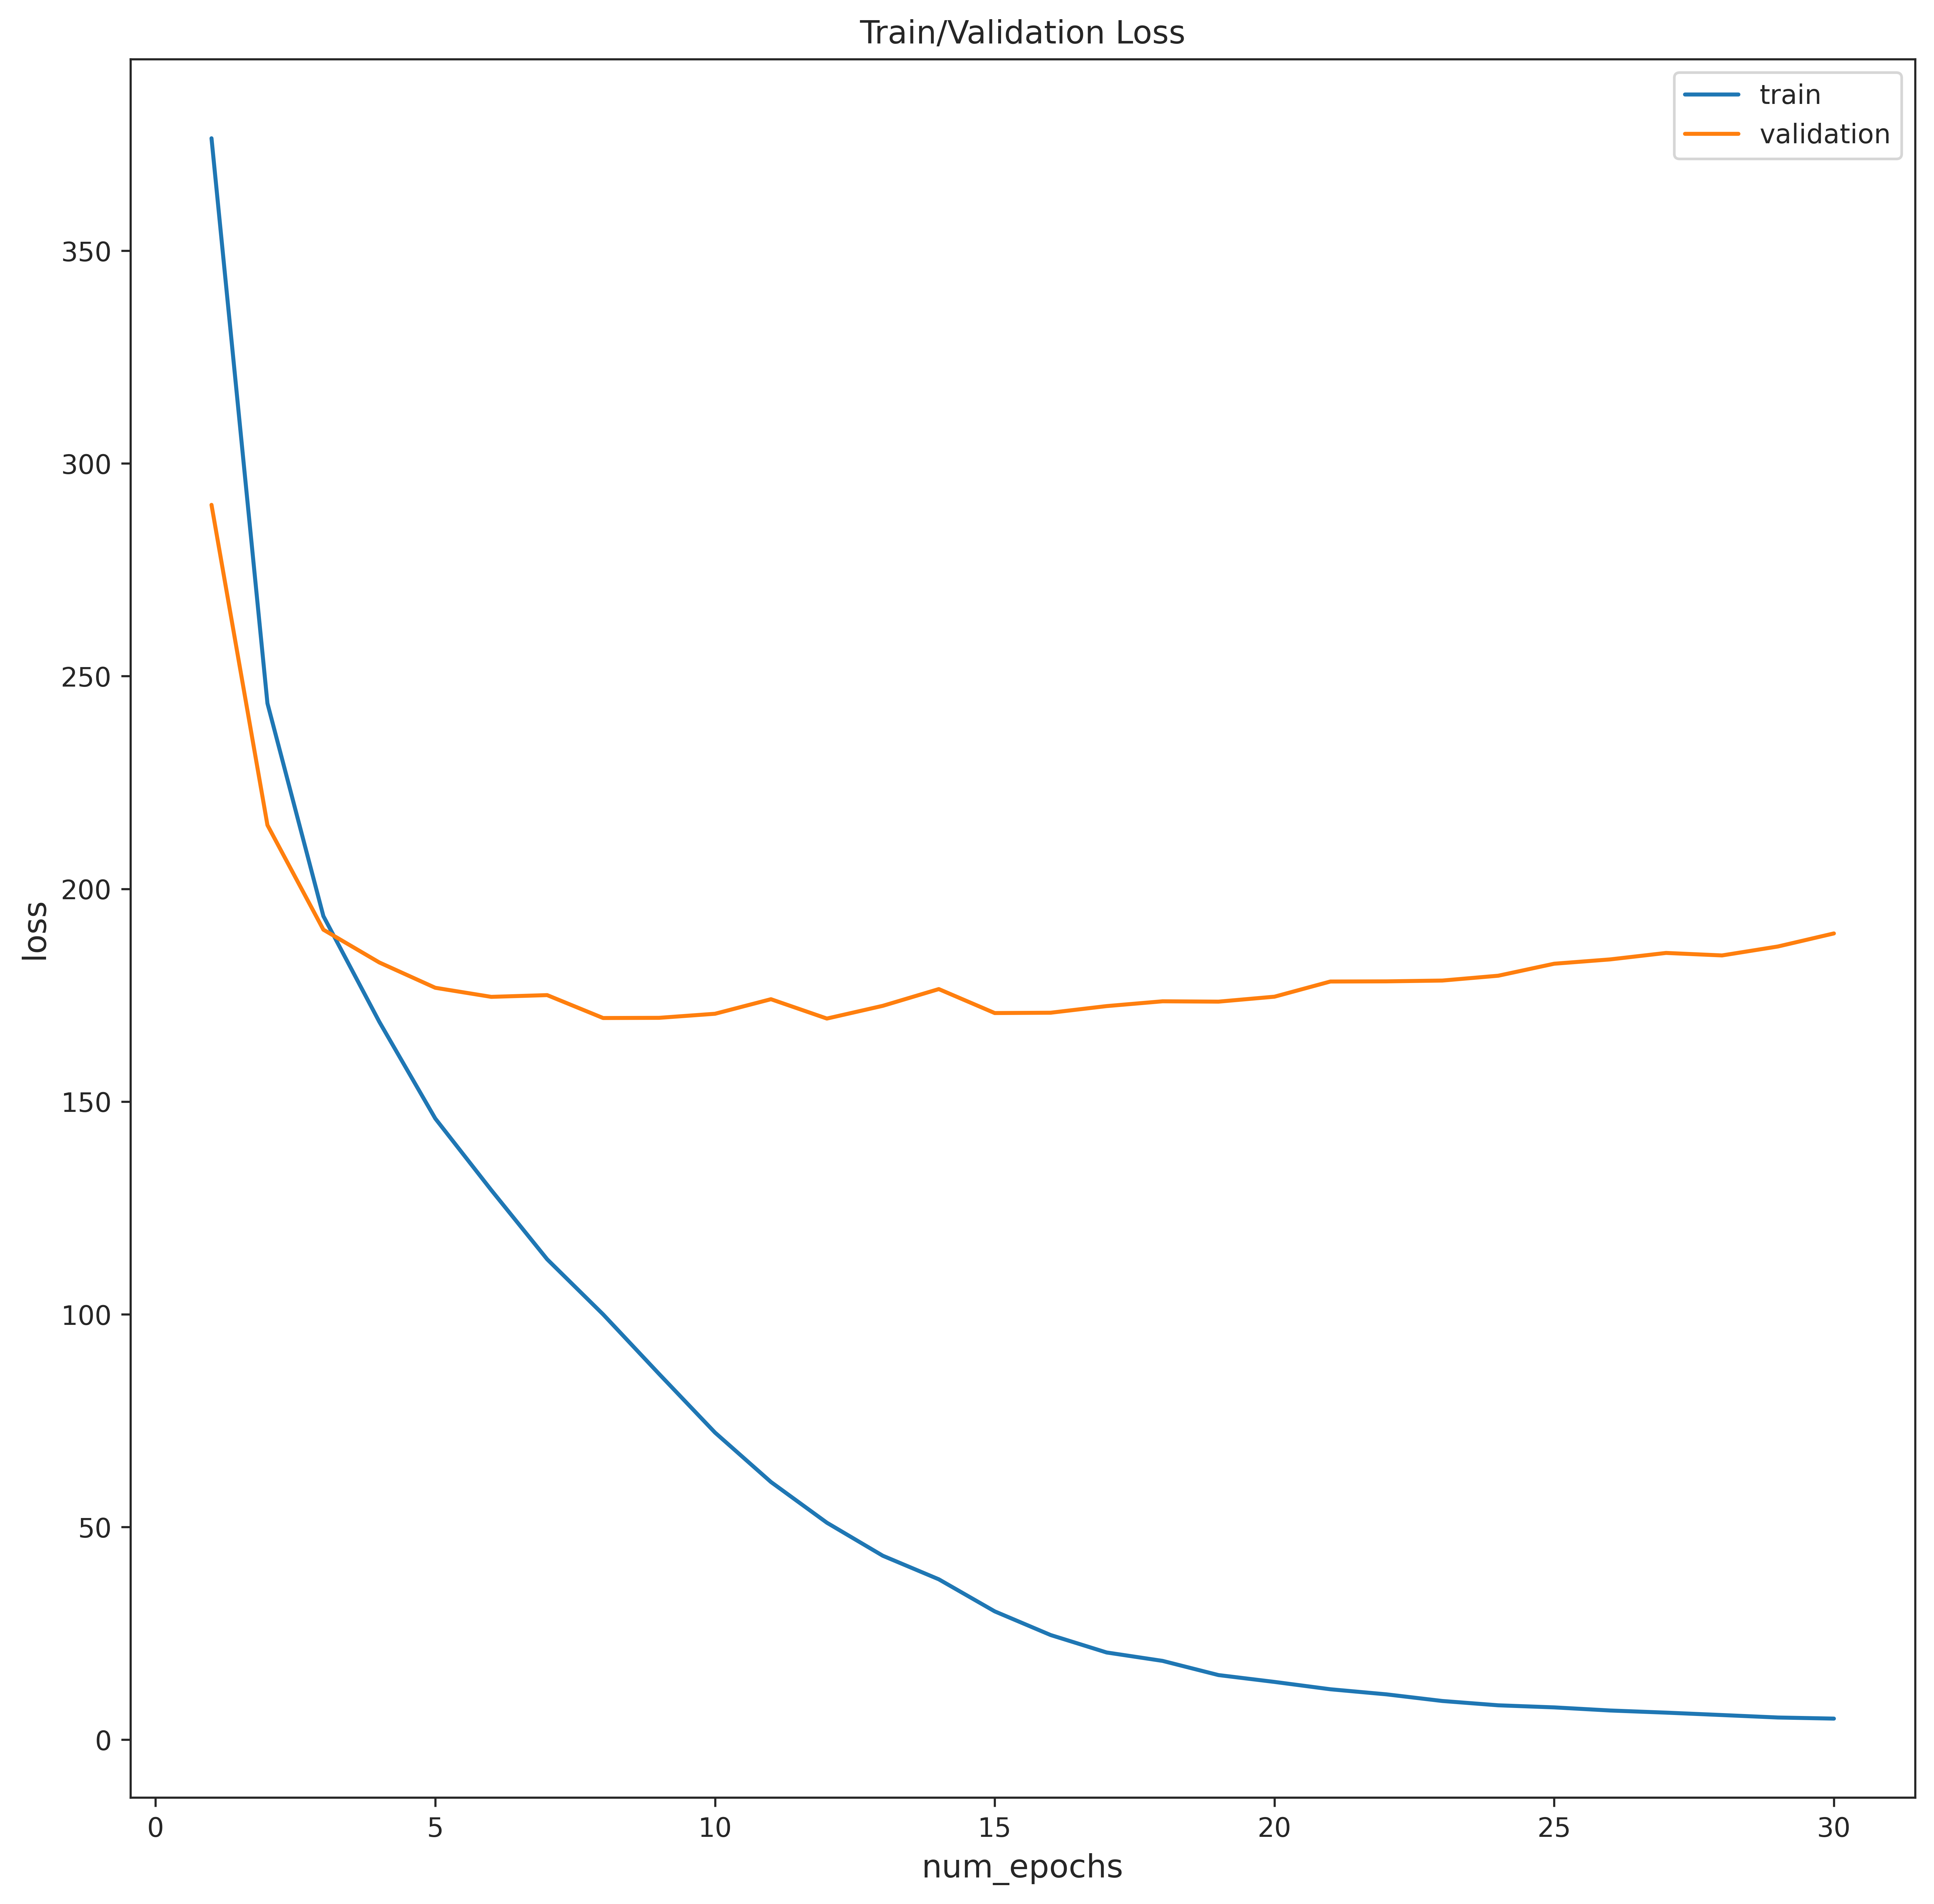

In [45]:
plot_graph(n_epochs)

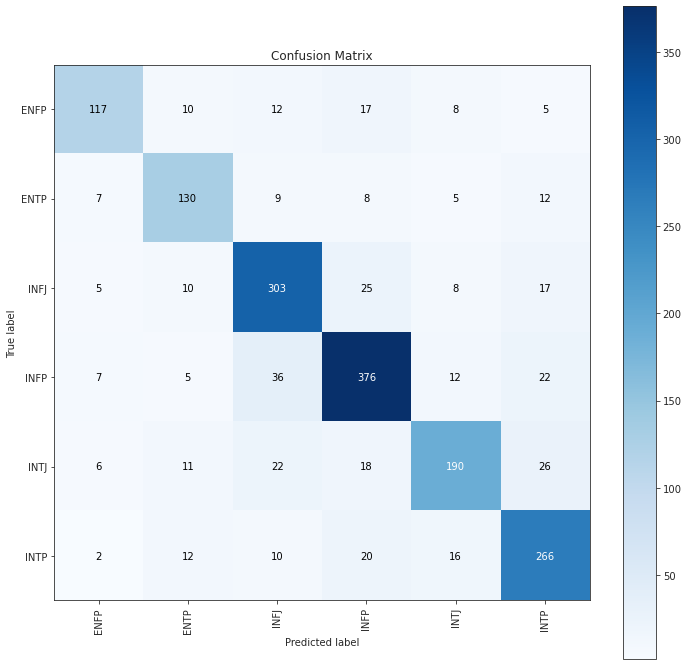

In [46]:
import scikitplot as skplt
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)

In [47]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        ENFP       0.81      0.69      0.75       169
        ENTP       0.73      0.76      0.74       171
        INFJ       0.77      0.82      0.80       368
        INFP       0.81      0.82      0.82       458
        INTJ       0.79      0.70      0.74       273
        INTP       0.76      0.82      0.79       326

    accuracy                           0.78      1765
   macro avg       0.78      0.77      0.77      1765
weighted avg       0.78      0.78      0.78      1765

